# 🎯 Exclusive π⁰ Reconstruction — NPS Experiment (2023–2024)

## ✨ Physics Motivation

We aim to extract the **exclusive cross section** for the process:

$
e + p \rightarrow e' + \pi^0 + p'
$

in which:
- The scattered electron is detected in the **HMS**.
- The two photons from π⁰ decay (π⁰ → γγ) are detected in the **NPS**.
- We do **not detect the recoil proton**, so we will apply an **exclusive cut** based on the **missing mass = proton mass**.

---

## 📁 Data Summary

- **Experiment**: NPS run group (Sept 2023 – May 2024)
- **Input**: Skimmed ROOT files located at  
  `/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/pi0_skimmed/`
- **Event structure**: one electron in HMS and two neutral clusters in NPS


In [3]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from vector import array as vec_array

# Physical constants
M_PROTON = 0.938  # GeV
M_PION0  = 0.135  # GeV

# Optional: Style
plt.style.use("seaborn-v0_8-poster")


In [4]:
# Load skimmed data file
file_path = "/home/ubuntu/nps_analysis/pi0_analysis/data/nps_hms_coin_skimmed_4398.root"
tree = uproot.open(file_path)["T"]

# Load branches
branches = tree.arrays([
    "T.hms.hEDTM_tdcTimeRaw", "T.hms.hTRIG4_tdcTimeRaw", "H.cal.etot", "H.cal.etotnorm",
    "H.cal.etottracknorm", "H.cal.etrack", "H.cal.etracknorm",
    "H.cer.npeSum", "H.gtr.dp", "H.gtr.th", "H.gtr.ph", "H.gtr.y", "H.gtr.p", 
    "H.gtr.px", "H.gtr.py", "H.gtr.pz", "H.gtr.x", "H.gtr.y", "NPS.cal.nclust", "NPS.cal.clusE",
    "NPS.cal.clusX", "NPS.cal.clusY", "NPS.cal.clusT"
])

tree.keys()

['Ndata.NPS.cal.clusE',
 'NPS.cal.clusE',
 'Ndata.NPS.cal.clusT',
 'NPS.cal.clusT',
 'Ndata.NPS.cal.clusX',
 'NPS.cal.clusX',
 'Ndata.NPS.cal.clusY',
 'NPS.cal.clusY',
 'H.cal.etot',
 'H.cal.etotnorm',
 'H.cal.etottracknorm',
 'H.cal.etrack',
 'H.cal.etracknorm',
 'H.cer.npeSum',
 'H.gtr.dp',
 'H.gtr.p',
 'H.gtr.ph',
 'H.gtr.px',
 'H.gtr.py',
 'H.gtr.pz',
 'H.gtr.th',
 'H.gtr.x',
 'H.gtr.y',
 'NPS.cal.nclust',
 'T.hms.hEDTM_tdcTimeRaw',
 'T.hms.hTRIG1_tdcTimeRaw',
 'T.hms.hTRIG2_tdcTimeRaw',
 'T.hms.hTRIG3_tdcTimeRaw',
 'T.hms.hTRIG4_tdcTimeRaw',
 'T.hms.hTRIG5_tdcTimeRaw',
 'T.hms.hTRIG6_tdcTimeRaw']

# Background subtractions

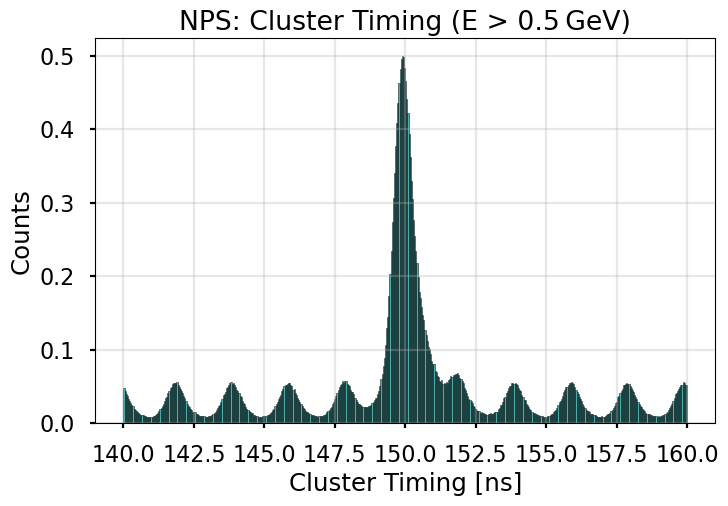

In [4]:
clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]

# Apply mask per cluster, preserving jagged structure
mask = clusE > 0.5

# Apply mask before flattening
clusT_selected = clusT[mask]

# Flatten to 1D array for histogramming
clusT_flat = ak.to_numpy(ak.flatten(clusT_selected))

plt.figure(figsize=(8,5))
plt.hist(clusT_flat, bins=500, range=(140,160), density=True,
         color="darkcyan", edgecolor="black", alpha=0.7)
plt.xlabel("Cluster Timing [ns]")
plt.ylabel("Counts")
plt.title("NPS: Cluster Timing (E > 0.5 GeV)")
plt.grid(True, alpha=0.3)
plt.show()

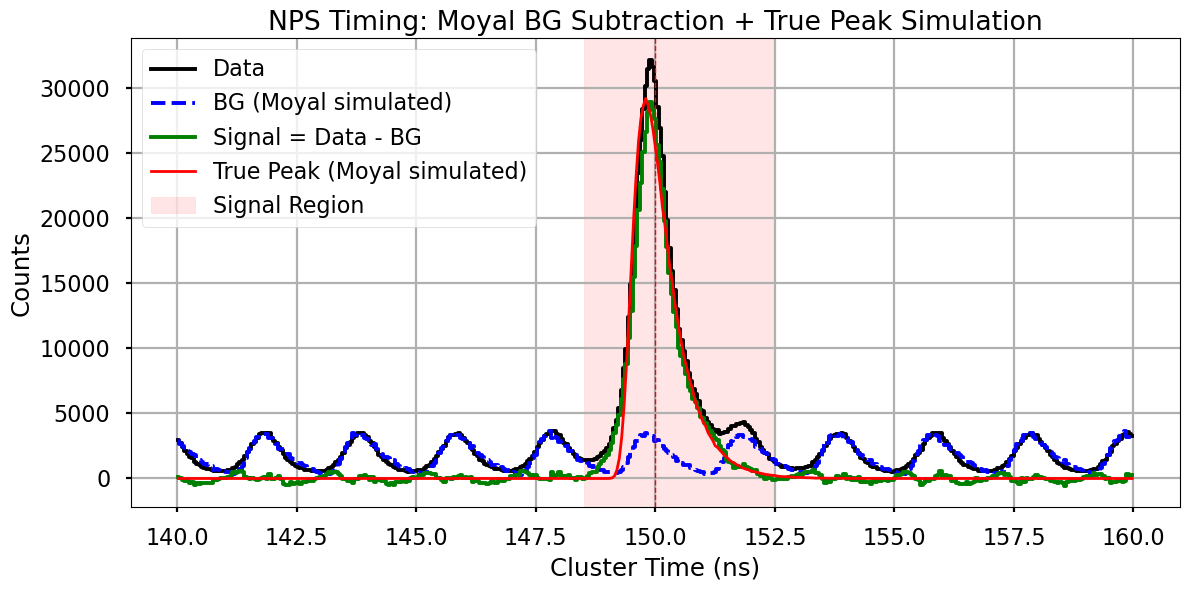

Scale factor for background: 4.265
Scale factor for simulated true peak: 0.598


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moyal
from scipy.stats import landau
import awkward as ak

clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]

# Apply mask per cluster, preserving jagged structure
mask = clusE > 0.5

# Apply mask before flattening
clusT_selected = clusT[mask]

# Flatten to 1D array for histogramming
clusT_flat = ak.to_numpy(ak.flatten(clusT_selected))


# === Load real data ===
# clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))
clusT = clusT_flat

# === Parameters ===
beam_bucket_spacing = 2.0        # ns
n_buckets = 200                  # +/- 400 ns window
true_peak_time = 150.0           # ns
timing_resolution = 0.25          # ns
n_true_events = 1000000
n_bg_per_bucket = 16000
# time_offset = 0.1 # 
time_offset = 0.2 # Moyal

# === Histogram bins ===
bins = np.linspace(140, 160, 400)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# === Simulate Background using Moyal ===
bg_times = []
for i in range(-n_buckets, n_buckets + 1):
    t_bucket = true_peak_time + i * beam_bucket_spacing
    bg_cluster_times = moyal.rvs(loc=t_bucket - time_offset, scale=timing_resolution, size=n_bg_per_bucket)
    bg_times.extend(bg_cluster_times)

bg_times = np.array(bg_times)

# === Histogram data and background ===
hist_data, _ = np.histogram(clusT, bins=bins)
hist_bg, _ = np.histogram(bg_times, bins=bins)

# === Background normalization using sidebands ===
sideband_mask = ((bin_centers < 148.5) | (bin_centers > 152.5))
data_sb_sum = np.sum(hist_data[sideband_mask])
sim_sb_sum = np.sum(hist_bg[sideband_mask])
scale_factor_bg = data_sb_sum / sim_sb_sum if sim_sb_sum > 0 else 0
scaled_bg = hist_bg * scale_factor_bg

# === Background-subtracted signal ===
subtracted = hist_data - scaled_bg

# === Simulate true signal using Moyal ===
true_signal_sim_samples = moyal.rvs(loc=true_peak_time - time_offset, scale=timing_resolution, size=n_true_events)
hist_true_signal_sim, _ = np.histogram(true_signal_sim_samples, bins=bins)
# hist_true_signal_sim = hist_true_signal_sim / np.sum(hist_true_signal_sim)  # Normalize

# === Normalize true peak to match signal region area ===
signal_region_mask = ((bin_centers > 148.5) & (bin_centers < 152.5))
area_data_signal = np.sum(subtracted[signal_region_mask])
area_true_sim = np.sum(hist_true_signal_sim[signal_region_mask])
scale_factor_signal = area_data_signal / area_true_sim if area_true_sim > 0 else 0
scaled_true_signal = hist_true_signal_sim * scale_factor_signal

# === Plot ===
plt.figure(figsize=(12, 6))
plt.step(bin_centers, hist_data, where='mid', color='black', label='Data')
plt.step(bin_centers, scaled_bg, where='mid', color='blue', linestyle='--', label='BG (Moyal simulated)')
plt.step(bin_centers, subtracted, where='mid', color='green', label='Signal = Data - BG')
plt.plot(bin_centers, scaled_true_signal, color='red', lw=2, label='True Peak (Moyal simulated)')
plt.axvspan(148.5, 152.5, color='red', alpha=0.1, label='Signal Region')
plt.axvline(true_peak_time, color='red', linestyle='--', linewidth=1)
plt.xlabel("Cluster Time (ns)")
plt.ylabel("Counts")
plt.title("NPS Timing: Moyal BG Subtraction + True Peak Simulation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Scale factor for background: {scale_factor_bg:.3f}")
print(f"Scale factor for simulated true peak: {scale_factor_signal:.3f}")


Generated 887102 2-cluster pairs.


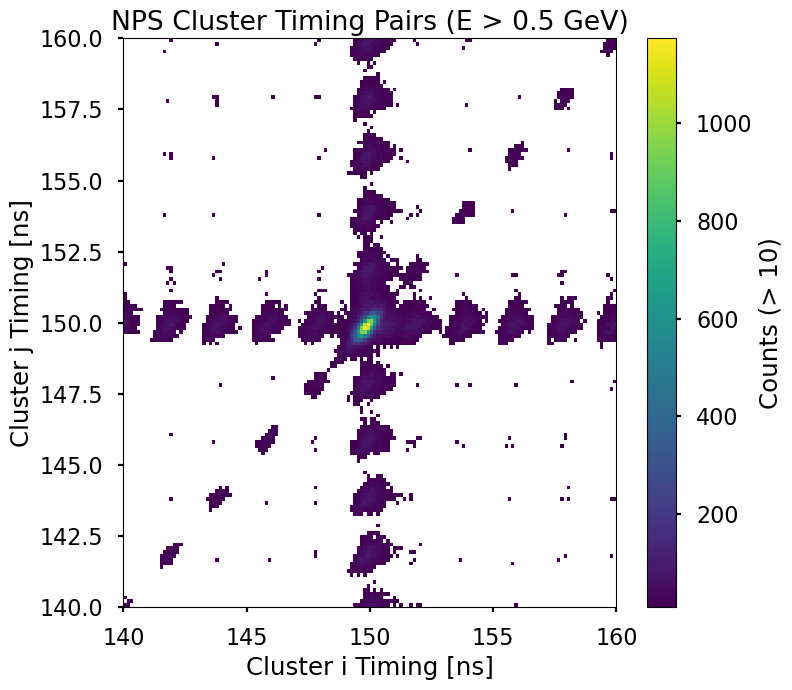

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]

# Apply cluster energy cut
mask = clusE > 0.5
clusT_selected = clusT[mask]

# Keep only events with at least 2 clusters after masking
mask_two_clusters = ak.num(clusT_selected) >= 2
clusT_two = clusT_selected[mask_two_clusters]

# Extract first and second cluster times
clusT0 = ak.to_numpy(clusT_two[:, 0])
clusT1 = ak.to_numpy(clusT_two[:, 1])

# print(f"Generated {len(clusT0)} 2-cluster pairs.")

# # --- 2D Histogram ---
# plt.figure(figsize=(8, 7))
# hist = plt.hist2d(clusT0, clusT1, bins=[150, 150], range=[[145, 155], [145, 155]], 
#                   cmap='viridis', norm=None)

# plt.colorbar(label='Counts')
# plt.xlabel("Cluster 1 Timing [ns]")
# plt.ylabel("Cluster 2 Timing [ns]")
# plt.title("NPS: Cluster 1 vs Cluster 2 Timing (E > 0.5 GeV)")
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# === 2D Histogram ===
bins = 150
hist_range = [[140, 160], [140, 160]]
counts, xedges, yedges = np.histogram2d(clusT0, clusT1, bins=bins, range=hist_range)

# === Apply threshold ===
threshold = 10  # Only show bins with counts > threshold
counts_masked = np.where(counts > threshold, counts, np.nan)  # Mask low-count bins

print(f"Generated {len(clusT0)} 2-cluster pairs.")

# === Plot masked 2D histogram ===
plt.figure(figsize=(8,7))
X, Y = np.meshgrid(xedges, yedges)
pcm = plt.pcolormesh(X, Y, counts_masked.T, cmap='viridis')  # Transpose for correct orientation
plt.colorbar(label=f'Counts (> {threshold})')
plt.xlabel("Cluster i Timing [ns]")
plt.ylabel("Cluster j Timing [ns]")
plt.title(f"NPS Cluster Timing Pairs (E > 0.5 GeV)")
plt.grid(False)
plt.tight_layout()
plt.show()


Generated 1818248 2-cluster pairs.


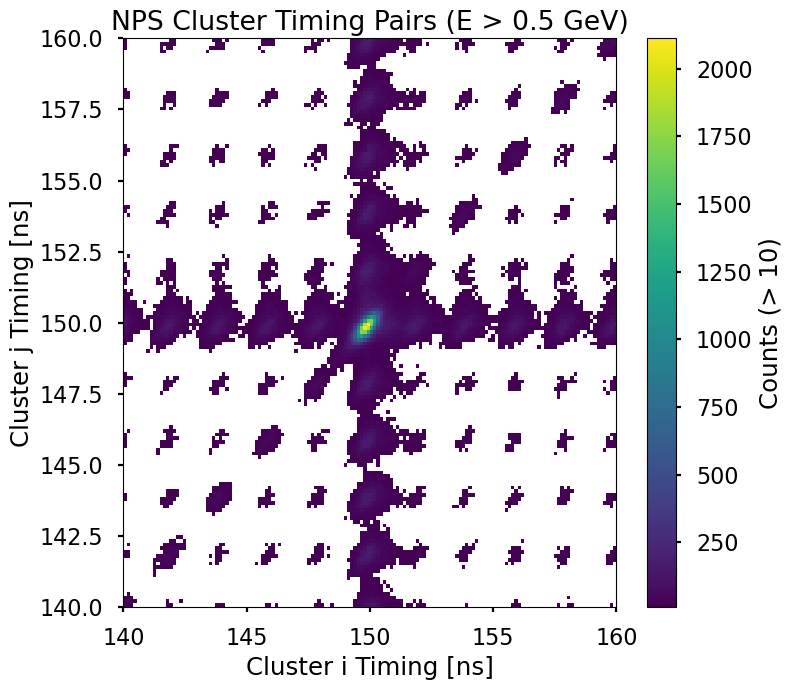

In [ ]:
# All 2-pair cluster combinations

import numpy as np
import matplotlib.pyplot as plt

# === Prepare all cluster pairs from multi-cluster events ===
clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]

mask = clusE > 0.5
clusT_selected = clusT[mask]

# Generate all possible cluster timing pairs (i,j) for multi-cluster events
clus_pairs = []
for event in ak.to_list(clusT_selected):
    if len(event) > 1:
        for i in range(len(event)):
            for j in range(i+1, len(event)):
                clus_pairs.append((event[i], event[j]))

clus_pairs = np.array(clus_pairs)
clus_pairs_0 = clus_pairs[:, 0]
clus_pairs_1 = clus_pairs[:, 1]

# === 2D Histogram ===
bins = 150
hist_range = [[140, 160], [140, 160]]
counts, xedges, yedges = np.histogram2d(clus_pairs_0, clus_pairs_1, bins=bins, range=hist_range)

# === Apply threshold ===
threshold = 10  # Only show bins with counts > threshold
counts_masked = np.where(counts > threshold, counts, np.nan)  # Mask low-count bins

print(f"Generated {len(clus_pairs_0)} 2-cluster pairs.")

# === Plot masked 2D histogram ===
plt.figure(figsize=(8,7))
X, Y = np.meshgrid(xedges, yedges)
pcm = plt.pcolormesh(X, Y, counts_masked.T, cmap='viridis')  # Transpose for correct orientation
plt.colorbar(label=f'Counts (> {threshold})')
plt.xlabel("Cluster i Timing [ns]")
plt.ylabel("Cluster j Timing [ns]")
plt.title(f"NPS Cluster Timing Pairs (E > 0.5 GeV)")
plt.grid(False)
plt.tight_layout()
plt.show()


# $\pi^0$ invariant mass with Opening Angle Calculation

The neutral pion decays via:

$$
\pi^0 \to \gamma\gamma
$$

Using four-momentum conservation:

$$
P_\pi^2 = (P_{\gamma_1} + P_{\gamma_2})^2
$$

Expanding the right-hand side:

$$
m_\pi^2 = P_{\gamma_1}^2 + P_{\gamma_2}^2 + 2P_{\gamma_1}^\mu P_{\gamma_2\mu}
$$

Since photons are massless, $ P_{\gamma_i}^2 = 0 $, so:

$$
m_\pi^2 = 2P_{\gamma_1}^\mu P_{\gamma_2\mu}
$$

Using the inner product of four-vectors:

$$
m_\pi^2 = 2 \left( E_{\gamma_1}E_{\gamma_2} - \vec{p}_{\gamma_1} \cdot \vec{p}_{\gamma_2} \right)
$$

The dot product can be written in terms of the opening angle $\theta$ between the two photons:

$$
\vec{p}_{\gamma_1} \cdot \vec{p}_{\gamma_2} = |\vec{p}_{\gamma_1}||\vec{p}_{\gamma_2}|\cos\theta
$$

Since $ |\vec{p}_{\gamma_i}| = E_{\gamma_i} $ for photons:

$$
m_\pi^2 = 2E_{\gamma_1}E_{\gamma_2}(1 - \cos\theta)
$$

Using the identity $( 1 - \cos\theta = 2\sin^2(\theta/2) )$, we get:

$$
m_\pi^2 = 4E_{\gamma_1}E_{\gamma_2} \sin^2(\theta/2)
$$

Solving for the opening angle $\theta$:

$$
\theta = 2 \sin^{-1}\left( \frac{m_\pi}{\sqrt{4E_{\gamma_1}E_{\gamma_2}}} \right)
$$

This relation can be used as a **kinematic constraint** to validate whether a photon pair is consistent with originating from a real $ \pi^0 $ decay.


In [ ]:
# function to reconcstruct invariant neutral pion mass taking into account the opening angle

import numba as nb
import numpy as np
from tqdm import tqdm
import pandas as pd

M_PION0  = 0.135  # GeV

@nb.njit
def reconstruct_pi0_mass_fast_w_opening_angle(e1, e2, x1, y1, x2, y2, z_nps=407): # z_nps in cm
    r1 = np.array([x1, y1, z_nps])
    r2 = np.array([x2, y2, z_nps])
    norm1 = np.sqrt(np.sum(r1 ** 2))
    norm2 = np.sqrt(np.sum(r2 ** 2))
    u1 = r1 / norm1
    u2 = r2 / norm2
    p1 = e1 * u1
    p2 = e2 * u2
    total_E = e1 + e2
    total_p = p1 + p2

    # Opening angle cut
    theta_ideal = 2 * np.arcsin(M_PION0 / np.sqrt(4 * e1 * e2))
    dot = np.dot(u1, u2)
    dot = min(1.0, max(-1.0, dot))  # Clamp to avoid NaNs from rounding errors
    theta_data = np.arccos(dot)


    # block_dim = 0.0205 # 2.05 x 2.05 cm^2 PbWO4 scintillator block
    theta_tolerance_rad = 0.01 # considering a cluster size of 4x4 blocks and the distance of NPS of 4.07 m. theta = (4x0.0205)/nps_distance

    if np.abs(theta_data - theta_ideal) < theta_tolerance_rad:  # radians
        m2 = total_E**2 - np.dot(total_p, total_p)
        return np.sqrt(m2) if m2 > 0 else 0.0
    else:
        return 0.0  # Or np.nan if you prefer masking out

In [6]:
from tqdm import tqdm

masses = []

for event in tqdm(branches, desc="Processing events"):
    e = np.asarray(event["NPS.cal.clusE"])
    x = np.asarray(event["NPS.cal.clusX"])
    y = np.asarray(event["NPS.cal.clusY"])
    if len(e) < 2:
        continue
    idx = np.argsort(e)[-2:]
    masses.append(reconstruct_pi0_mass_fast_w_opening_angle(
        e[idx[0]], e[idx[1]],
        x[idx[0]], y[idx[0]],
        x[idx[1]], y[idx[1]]
    ))

df_invariant_pi0 = pd.DataFrame(masses)

df_invariant_pi0.to_csv("invariant_mass_pi0_w_opening_angle.csv", mode = 'w', index=False)

Processing events: 100%|██████████| 3222394/3222394 [09:19<00:00, 5760.81it/s] 


<>:46: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:46: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_13917/2480461501.py:46: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(0.13498, color='red', linestyle='--', label='PDG $\pi^0$ Mass (134.98 MeV)')
/tmp/ipykernel_13917/2480461501.py:51: SyntaxWarning: invalid escape sequence '\p'
  plt.title(f"Reconstructed $\pi^0$ Mass (Fit in {fit_threshold_low} - {fit_threshold_high} GeV)", fontsize=16)


Fitted Mean: 0.1324 GeV
Fitted Std Dev: 0.0055 GeV


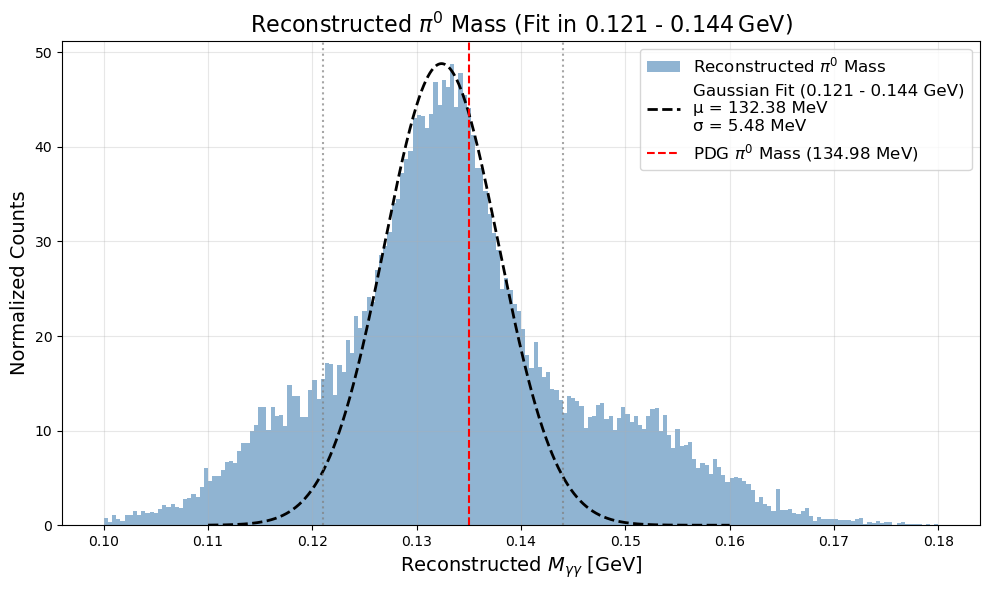

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

# --- Load invariant mass data ---
df = pd.read_csv('pi0_mass_theta_data.csv')
masses = df['mass_w_opening_angle'].to_numpy()

fit_threshold_low = 0.121
fit_threshold_high = 0.144
# --- Fit only within the signal region 0.12–0.14 GeV ---
fit_mask = (masses > fit_threshold_low) & (masses < fit_threshold_high)
masses_fit = masses[fit_mask]

# Gaussian fit
mu, std = norm.fit(masses_fit)

print(f"Fitted Mean: {mu:.4f} GeV")
print(f"Fitted Std Dev: {std:.4f} GeV")

# --- Plot histogram of full range (for context) ---
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(
    masses, bins=200, range=(0.1, 0.18),
    density=True, color="steelblue", alpha=0.6,
    label=r"Reconstructed $\pi^0$ Mass"
)

# --- Gaussian fit over the fit range only ---
x_fit = np.linspace(0.11, 0.16, 1000)
p_fit = norm.pdf(x_fit, mu, std)

# Scale Gaussian to histogram maximum
scale_factor = counts.max() / norm.pdf(mu, mu, std)

plt.plot(x_fit, p_fit*scale_factor, 'k--', lw=2,
         label=fr'Gaussian Fit ({fit_threshold_low} - {fit_threshold_high} GeV)'
               + f'\nμ = {1000*mu:.2f} MeV\nσ = {1000*std:.2f} MeV')

# --- Add vertical lines for the fit region ---
plt.axvline(fit_threshold_low, color='gray', linestyle=':', alpha=0.7)
plt.axvline(fit_threshold_high, color='gray', linestyle=':', alpha=0.7)

# --- PDG π0 mass line ---
plt.axvline(0.13498, color='red', linestyle='--', label='PDG $\pi^0$ Mass (134.98 MeV)')

# Labels and formatting
plt.xlabel(r"Reconstructed $M_{\gamma\gamma}$ [GeV]", fontsize=14)
plt.ylabel("Normalized Counts", fontsize=14)
plt.title(f"Reconstructed $\pi^0$ Mass (Fit in {fit_threshold_low} - {fit_threshold_high} GeV)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [2]:
df

,0,1,2,3
0,mass_all,mass_w_opening_angle,theta_data,theta_ideal
1,0.12913595739231262,0.12913595739231262,0.08320876456113689,0.08697669803593061
2,0.14004540183130246,0.14004540183130246,0.0808431457789403,0.0779175643937577
3,0.13573296150412797,0.13573296150412797,0.0645934309692176,0.06423498344574627
4,0.12512780225432682,0.12512780225432682,0.09742640212636158,0.10510428337638829
...,...,...,...,...
79609,0.1139767509939971,0.1139767509939971,0.04992210209427212,0.059124049747791
79610,0.15859760378570442,0.15859760378570442,0.09570030002580801,0.08144049156458574
79611,0.269225701286452,0.0,0.14937495938115036,0.07483904260883117
79612,0.1407568142547059,0.1407568142547059,0.09142249596473931,0.08766795978540354
